# Preprocessing

## Removing folders with < 4 images

In [1]:
import shutil
import os

source_dir = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled"
dest_dir = "/kaggle/working/lfw-deepfunneled_cleaned"

shutil.copytree(source_dir, dest_dir)
print(f"Copied dataset to {dest_dir}")

Copied dataset to /kaggle/working/lfw-deepfunneled_cleaned


In [2]:
from tqdm.notebook import tqdm
import numpy as np
import cv2

def remove_small_folders(directory, min_files):
    removed_folders, total_folders = 0, 0
    
    for foldername in os.listdir(directory):
        total_folders += 1
        folder_path = os.path.join(directory, foldername)
        if os.path.isdir(folder_path):
            files_in_folder = os.listdir(folder_path)
            if len(files_in_folder) < min_files:
                # print(f"Removing folder: {folder_path}")
                removed_folders += 1
                shutil.rmtree(folder_path) # for removing extra folders
    print(f'Removed {removed_folders} folders out of {total_folders}')

# Our Labelled Faces in the Wild (LFW) dataset in the Google Drive
directory_path = "/kaggle/working/lfw-deepfunneled_cleaned"
min_files_count = 4

In [3]:
remove_small_folders(directory_path, min_files_count)

Removed 5139 folders out of 5749


In [ ]:
!pip install deepface

In [ ]:
!pip install ultralytics

## Example of cropping an image with Yolov8 backbone

2025-05-09 13:30:34.755975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746797435.009192      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746797435.079829      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


25-05-09 13:30:47 - Directory /root/.deepface has been created
25-05-09 13:30:47 - Directory /root/.deepface/weights has been created
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
25-05-09 13:30:51 - Downloading Yolo weights from https://drive.google.com/uc?id=1qcr9DbgsX3ryrz2uU8w4Xm3cOrRywXqb to /root/.deepface/weights/yolov8n-face.pt...


Downloading...
From (original): https://drive.google.com/uc?id=1qcr9DbgsX3ryrz2uU8w4Xm3cOrRywXqb
From (redirected): https://drive.google.com/uc?id=1qcr9DbgsX3ryrz2uU8w4Xm3cOrRywXqb&confirm=t&uuid=1b526924-a9c4-4803-bbd5-c6b2e39aa491
To: /root/.deepface/weights/yolov8n-face.pt
100%|██████████| 6.39M/6.39M [00:00<00:00, 132MB/s]


25-05-09 13:31:26 - Yolo model is just downloaded to yolov8n-face.pt


(140, 100, 3)

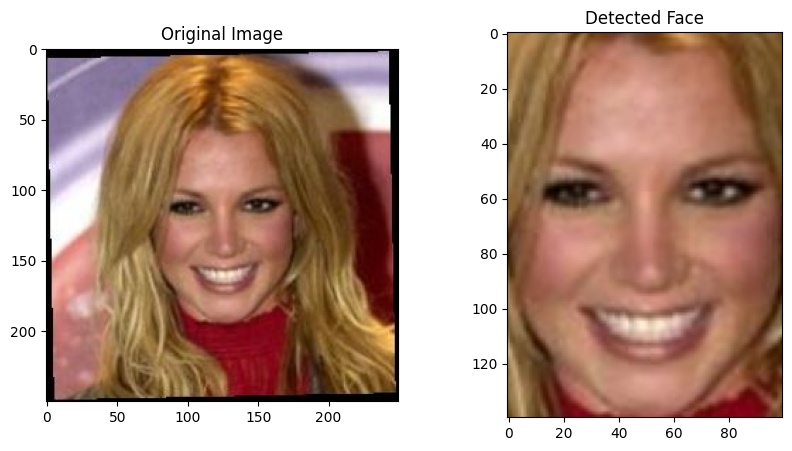

In [7]:
from deepface import DeepFace
import cv2
from  matplotlib import pyplot as plt
import ultralytics

path = '/kaggle/working/lfw-deepfunneled_cleaned/Britney_Spears/Britney_Spears_0001.jpg'
face_objs = DeepFace.extract_faces(img_path = path,
        #target_size = (224, 224),
        detector_backend = 'yolov8'
    )
face_image = face_objs[0]['face']  # Extract the face image

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(plt.imread(path))
axs[0].set_title('Original Image')

axs[1].imshow(face_image)
axs[1].set_title('Detected Face')
face_image.shape

## Removing images where number of faces is less than 1 or more than 1

In [8]:
def remove_invalid_images(directory, min_faces=1, max_faces=1):
    removed_imgs, total_imgs = 0, 0
    
    for foldername in tqdm(os.listdir(directory)):
        folder_path = os.path.join(directory, foldername)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                total_imgs += 1
                if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    image_path = os.path.join(folder_path, filename)
                    try:
                        # Trying to extract faces using Yolov8
                        face_objs = DeepFace.extract_faces(img_path=image_path, detector_backend='yolov8')
                        # Checking number of found faces
                        if len(face_objs) < min_faces or len(face_objs) > max_faces:
                            # print(f"Removing image: {image_path}")
                            removed_imgs += 1
                            os.remove(image_path)
                    except Exception as e:
                        print(f"Error processing image {image_path}: {e}")
                        os.remove(image_path)
    print(f'Removed {removed_imgs} images out of {total_imgs}')

directory_path = '/kaggle/working/lfw-deepfunneled_cleaned'

# Min and max number of faces allowed on a photo
min_faces_count = 1
max_faces_count = 1

remove_invalid_images(directory_path, min_faces_count, max_faces_count)

  0%|          | 0/610 [00:00<?, ?it/s]

Removed 1387 images out of 6733


## Removing small folders again (there can be some folders that have <4 images now because I removed photos with != 1 number of faces)

In [10]:
remove_small_folders('/kaggle/working/lfw-deepfunneled_cleaned', min_files_count)

Removed 154 folders out of 610


## Cropping only faces and saving them in a separate folder

In [ ]:
def crop_and_save_faces(src_directory, dest_directory, min_faces=1, max_faces=1):
    # Creating a folder if it does not exist
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)

    for foldername in tqdm(os.listdir(src_directory), desc="Processing folders"):
        src_folder_path = os.path.join(src_directory, foldername)
        dest_folder_path = os.path.join(dest_directory, foldername)

        if os.path.isdir(src_folder_path):
            if not os.path.exists(dest_folder_path):
                os.makedirs(dest_folder_path)

            for filename in tqdm(os.listdir(src_folder_path), desc=f"Processing images in {foldername}"):
                if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    src_image_path = os.path.join(src_folder_path, filename)
                    dest_image_path = os.path.join(dest_folder_path, filename)

                    try:
                        # Extracting faces
                        face_objs = DeepFace.extract_faces(img_path=src_image_path, detector_backend='yolov8')
                        # Checking count
                        if min_faces <= len(face_objs) <= max_faces:
                            # Saving an image
                            face_image = face_objs[0]['face']
                            rgb_face_image = (face_image * 255).astype(np.uint8)
                            bgr_face_image = cv2.cvtColor(rgb_face_image, cv2.COLOR_RGB2BGR)
                            cv2.imwrite(dest_image_path, bgr_face_image)
                    except Exception as e:
                        print(f"Error processing image {src_image_path}: {e}")

# Source and destination paths
src_directory_path = '/kaggle/working/lfw-deepfunneled_cleaned'
dest_directory_path = '/kaggle/working/lfw-deepfunneled_cropped'

# Min and max number of faces allowed on a photo
min_faces_count = 1
max_faces_count = 1

crop_and_save_faces(src_directory_path, dest_directory_path, min_faces_count, max_faces_count)

In [24]:
import shutil

folder_path = "/kaggle/working/lfw-deepfunneled_cropped"  # replace with your actual folder
zip_path = "/kaggle/working/lfw-deepfunneled_cropped.zip"

# Create ZIP file
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', folder_path)
print(f"Zipped to: {zip_path}")


Zipped to: /kaggle/working/lfw-deepfunneled_cropped.zip


# Training

In [3]:
import torch
import torchvision

!python -V; printf '\n'
!nvcc -V; printf '\n'
print(f'CUDA is available: {torch.cuda.is_available()}')
print(f'Current device: {torch.cuda.current_device()}')
print(f'Device name: {torch.cuda.get_device_name(0)}')
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'CUDNN enabled: {torch.backends.cudnn.enabled}')
print(f'CUDA version by torch: {torch.version.cuda}')
print(f'Torchvision version: {torchvision.__version__}')
print(f'Torchvision loc: {torchvision.__file__}')

Python 3.11.11

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0

CUDA is available: True
Current device: 0
Device name: Tesla T4
CUDNN version: 90100
CUDNN enabled: True
CUDA version by torch: 12.4
Torchvision version: 0.20.1+cu124
Torchvision loc: /usr/local/lib/python3.11/dist-packages/torchvision/__init__.py


## Creating train/val/test splits

In [6]:
import os
import random
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

class LFWFacesDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        assert split in ['train', 'val', 'test'], "split must be 'train', 'val', or 'test'"
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.image_paths, self.labels = self._load_data()

    def _load_data(self):
        folders = sorted(os.listdir(self.root_dir))
        random.seed(42)
        random.shuffle(folders)

        num_folders = len(folders)
        train_end = int(0.7 * num_folders)
        val_end = int(0.85 * num_folders)

        if self.split == 'train':
            selected_folders = folders[:train_end]
        elif self.split == 'val':
            selected_folders = folders[train_end:val_end]
        else:  # test
            selected_folders = folders[val_end:]

        image_paths = []
        labels = []
        for i, folder in enumerate(selected_folders):
            folder_path = os.path.join(self.root_dir, folder)
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    image_paths.append(os.path.join(folder_path, filename))
                    labels.append(i)  # label = folder index within split

        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms for train and val (the normalizations here are original normalizations for ResNet from the paper)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = LFWFacesDataset('/kaggle/input/lfw-deepfunneled-cropped',
                                split='train',
                                transform=train_transform)

val_dataset = LFWFacesDataset('/kaggle/input/lfw-deepfunneled-cropped',
                              split='val',
                              transform=val_transform)

test_dataset = LFWFacesDataset('/kaggle/input/lfw-deepfunneled-cropped',
                               split='test',
                               transform=val_transform)

In [7]:
from torch.utils.data import Dataset, DataLoader

class TripletDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.class_indices = {}
        for idx, label in enumerate(dataset.labels):
            if label not in self.class_indices:
                self.class_indices[label] = []
            self.class_indices[label].append(idx)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        anchor_label = self.dataset.labels[idx]

        # Select positive sample from the same class
        positive_idx, anchor_idx = random.sample(self.class_indices[anchor_label],2)
        positive_img = self.dataset[positive_idx][0]
        anchor_img = self.dataset[anchor_idx][0]

        # Select negative sample from a different class
        negative_label = random.choice([label for label in self.class_indices.keys() if label != anchor_label])
        negative_idx = random.choice(self.class_indices[negative_label])
        negative_img = self.dataset[negative_idx][0]

        return anchor_img, positive_img, negative_img


train_triplet_dataset = TripletDataset(train_dataset)
val_triplet_dataset = TripletDataset(val_dataset)
test_triplet_dataset = TripletDataset(test_dataset)

train_loader = DataLoader(train_triplet_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_triplet_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_triplet_dataset, batch_size=16, shuffle=False)

## Creating triplets: one triplet contains an anchor, positive, and negative images

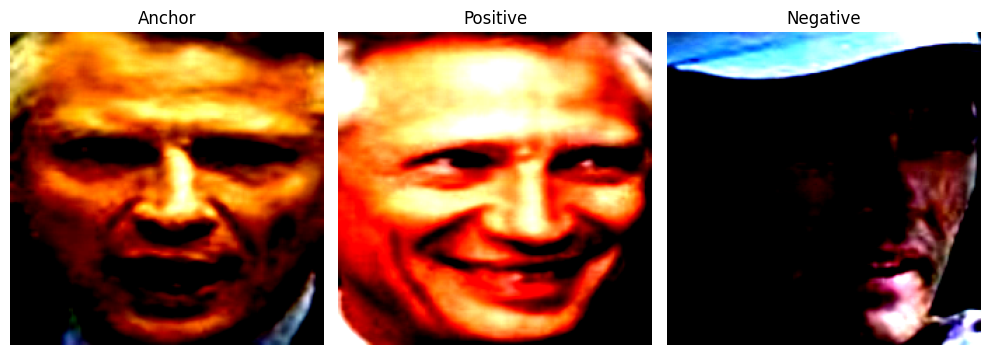

In [9]:
# Generating one triplet
anchors, positives, negatives = next(iter(train_loader))

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Transforming tensors into numpy arrays for visualization
anchors_np = anchors.permute(0, 2, 3, 1).numpy()
positives_np = positives.permute(0, 2, 3, 1).numpy()
negatives_np = negatives.permute(0, 2, 3, 1).numpy()

# Showing one triplet
axs[0].imshow(anchors_np[0])
axs[0].set_title('Anchor')
axs[1].imshow(positives_np[0])
axs[1].set_title('Positive')
axs[2].imshow(negatives_np[0])
axs[2].set_title('Negative')

# Removing axes
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

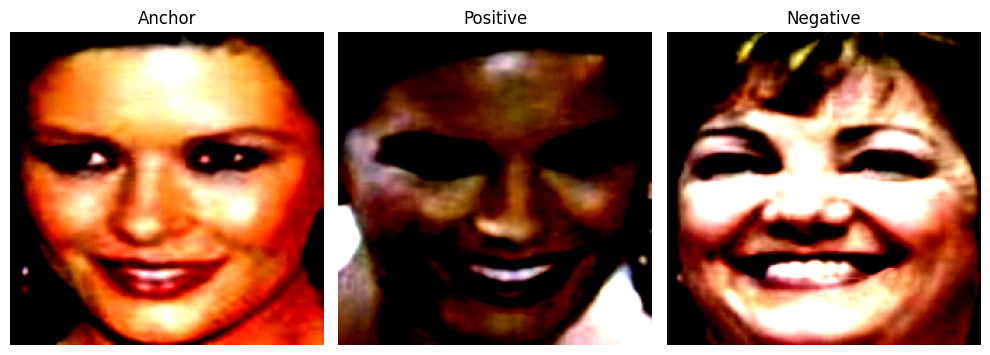

In [10]:
# Generating one triplet
anchors, positives, negatives = next(iter(val_loader))

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Transforming tensors into numpy arrays for visualization
anchors_np = anchors.permute(0, 2, 3, 1).numpy()
positives_np = positives.permute(0, 2, 3, 1).numpy()
negatives_np = negatives.permute(0, 2, 3, 1).numpy()

# Showing one triplet
axs[0].imshow(anchors_np[0])
axs[0].set_title('Anchor')
axs[1].imshow(positives_np[0])
axs[1].set_title('Positive')
axs[2].imshow(negatives_np[0])
axs[2].set_title('Negative')

# Removing axes
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

## Using TripletLoss for optimization

In [11]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [16]:
# Defining the training and validation procedures
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (anchors, positives, negatives) in tqdm(enumerate(train_loader), leave = False):
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
        optimizer.zero_grad()
        anchor_embeddings = model(anchors).squeeze(2,3)
        positive_embeddings = model(positives).squeeze(2,3)
        negative_embeddings = model(negatives).squeeze(2,3)
        loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #print(loss.item())
        #torch.cuda.empty_cache()
    avg_loss = running_loss / len(train_loader)
    print(f'Train Epoch: \tLoss: {avg_loss:.6f}')
    return avg_loss

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_idx, (anchors, positives, negatives) in tqdm(enumerate(val_loader), leave = False):
            anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
            anchor_embeddings = model(anchors).squeeze(2,3)
            positive_embeddings = model(positives).squeeze(2,3)
            negative_embeddings = model(negatives).squeeze(2,3)
            loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
            running_loss += loss.item()
            #torch.cuda.empty_cache()
            #print(loss.item())
    avg_loss = running_loss / len(val_loader)
    print(f'Val Epoch: \tLoss: {avg_loss:.6f}')
    return avg_loss

## Importing a pre-trained ResNet

In [22]:
import torch
from torchvision.models import resnet18

# Replace a model to CUDA if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading pre-trained ResNet-18/50
model = resnet18(weights='DEFAULT')
model = model.to(device).train()

# Removing AvgPool layer to get only features before fully connected layer
model = torch.nn.Sequential(*list(model.children())[:-1])

# Example of an inferenced batch and its dimensions
model(anchors.to(device)).squeeze(2,3).shape

torch.Size([16, 512])

In [23]:
criterion = TripletLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

## Training with early stopping (patience=3)

Val loss before training:


0it [00:00, ?it/s]

Val Epoch: 	Loss: 10.132298

----------------
Epoch 1/25 training:


0it [00:00, ?it/s]

Train Epoch: 	Loss: 4.343527


0it [00:00, ?it/s]

Val Epoch: 	Loss: 1.070754
Validation loss improved. Model saved to /kaggle/working/ResNet18_best.pth
Train duration: 55.43 sec
Val duration: 9.77 sec

----------------
Epoch 2/25 training:


0it [00:00, ?it/s]

Train Epoch: 	Loss: 0.772747


0it [00:00, ?it/s]

Val Epoch: 	Loss: 0.736196
Validation loss improved. Model saved to /kaggle/working/ResNet18_best.pth
Train duration: 55.22 sec
Val duration: 10.39 sec

----------------
Epoch 3/25 training:


0it [00:00, ?it/s]

Train Epoch: 	Loss: 0.596705


0it [00:00, ?it/s]

Val Epoch: 	Loss: 0.711883
Validation loss improved. Model saved to /kaggle/working/ResNet18_best.pth
Train duration: 54.08 sec
Val duration: 10.39 sec

----------------
Epoch 4/25 training:


0it [00:00, ?it/s]

Train Epoch: 	Loss: 0.646440


0it [00:00, ?it/s]

Val Epoch: 	Loss: 0.649610
Validation loss improved. Model saved to /kaggle/working/ResNet18_best.pth
Train duration: 54.81 sec
Val duration: 9.96 sec

----------------
Epoch 5/25 training:


0it [00:00, ?it/s]

Train Epoch: 	Loss: 0.518565


0it [00:00, ?it/s]

Val Epoch: 	Loss: 0.531887
Validation loss improved. Model saved to /kaggle/working/ResNet18_best.pth
Train duration: 53.92 sec
Val duration: 10.14 sec

----------------
Epoch 6/25 training:


0it [00:00, ?it/s]

Train Epoch: 	Loss: 0.439314


0it [00:00, ?it/s]

Val Epoch: 	Loss: 0.498900
Validation loss improved. Model saved to /kaggle/working/ResNet18_best.pth
Train duration: 53.72 sec
Val duration: 10.12 sec

----------------
Epoch 7/25 training:


0it [00:00, ?it/s]

Train Epoch: 	Loss: 0.404785


0it [00:00, ?it/s]

Val Epoch: 	Loss: 0.478607
Validation loss improved. Model saved to /kaggle/working/ResNet18_best.pth
Train duration: 53.52 sec
Val duration: 10.28 sec

----------------
Epoch 8/25 training:


0it [00:00, ?it/s]

Train Epoch: 	Loss: 0.336840


0it [00:00, ?it/s]

Val Epoch: 	Loss: 0.471027
Validation loss improved. Model saved to /kaggle/working/ResNet18_best.pth
Train duration: 54.12 sec
Val duration: 10.59 sec

----------------
Epoch 9/25 training:


0it [00:00, ?it/s]

Train Epoch: 	Loss: 0.351614


0it [00:00, ?it/s]

Val Epoch: 	Loss: 0.357409
Validation loss improved. Model saved to /kaggle/working/ResNet18_best.pth
Train duration: 54.64 sec
Val duration: 9.97 sec

----------------
Epoch 10/25 training:


0it [00:00, ?it/s]

Train Epoch: 	Loss: 0.251226


0it [00:00, ?it/s]

Val Epoch: 	Loss: 0.316063
Validation loss improved. Model saved to /kaggle/working/ResNet18_best.pth
Train duration: 54.75 sec
Val duration: 9.68 sec

----------------
Epoch 11/25 training:


0it [00:00, ?it/s]

Train Epoch: 	Loss: 0.242822


0it [00:00, ?it/s]

Val Epoch: 	Loss: 0.401695
No improvement. Patience: 1/3
Train duration: 54.13 sec
Val duration: 10.08 sec

----------------
Epoch 12/25 training:


0it [00:00, ?it/s]

Train Epoch: 	Loss: 0.229311


0it [00:00, ?it/s]

Val Epoch: 	Loss: 0.358611
No improvement. Patience: 2/3
Train duration: 70.82 sec
Val duration: 16.82 sec

----------------
Epoch 13/25 training:


0it [00:00, ?it/s]

Train Epoch: 	Loss: 0.211759


0it [00:00, ?it/s]

Val Epoch: 	Loss: 0.434986
No improvement. Patience: 3/3
Early stopping triggered after 13 epochs
Best model reloaded


/tmp/ipykernel_31/3423396476.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


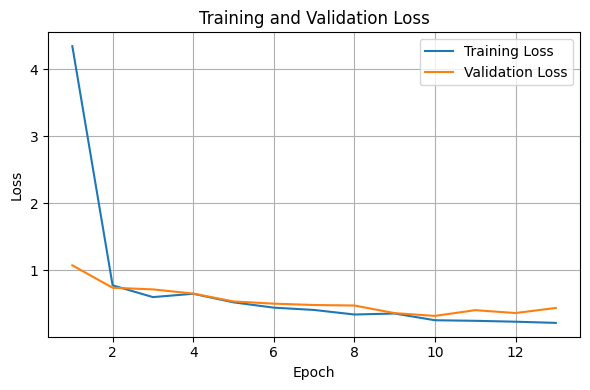

In [24]:
import torch
import matplotlib.pyplot as plt
import time

# Initial validation
print("Val loss before training:")
validate_epoch(model, val_loader, criterion, device)

# Config
num_epochs = 25
patience = 3
best_val_loss = float('inf')
patience_counter = 0

train_losses, val_losses = [], []
best_model_path = "/kaggle/working/ResNet18_best.pth"

# Epoch loop
for epoch in range(num_epochs):
    print("\n----------------")
    print(f"Epoch {epoch+1}/{num_epochs} training:")
    start_time = time.time()

    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_time = time.time() - start_time
    start_time = time.time()
    
    val_loss = validate_epoch(model, val_loader, criterion, device)
    val_time = time.time() - start_time

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Early stopping and saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Validation loss improved. Model saved to {best_model_path}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    print(f'Train duration: {train_time:.2f} sec')
    print(f'Val duration: {val_time:.2f} sec')

# Load best model after training
model.load_state_dict(torch.load(best_model_path))
print("Best model reloaded")

# Final Loss Plot
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
# Saving losses as a JSON file
import json
losses = {
    "train_losses": train_losses,
    "val_losses": val_losses
}


with open("resnet18_losses.json", "w") as json_file:
    json.dump(losses, json_file, indent=4)

In [26]:
model.eval()

# Scripted version of the model
scripted_model = torch.jit.script(model)

# Saving model in a scripted format - .pt
scripted_model.save('resnet18_scripted.pt')

# Testing

## Testing on images from the dataset

In [27]:
def plot_images(image_path1, image_path2):
    fig, axes = plt.subplots(1, 2, figsize=(6, 4))

    axes[0].imshow(plt.imread(image_path1))
    axes[0].set_title('Image 1')
    axes[0].axis('off')

    axes[1].imshow(plt.imread(image_path2))
    axes[1].set_title('Image 2')
    axes[1].axis('off')


def load_and_preprocess_image(image_path):
    # Loading and transforming
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image.unsqueeze(0)

def compute_distance(image1_path, image2_path, model, distance_metric='euclidean'):
    # Loading and preprocessing
    image1 = load_and_preprocess_image(image1_path)
    image2 = load_and_preprocess_image(image2_path)

    # Converting images to CUDA
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image1 = image1.to(device)
    image2 = image2.to(device)

    # Inference
    with torch.no_grad():
        output1 = model(image1)
        output2 = model(image2)

    # Distances between images
    if distance_metric == 'euclidean':
        distance = torch.norm(output1 - output2)
    elif distance_metric == 'cosine':
        distance = torch.nn.functional.cosine_similarity(output1, output2)
    else:
        raise ValueError("False distance metrics. Available metrics are: 'euclidean' or 'cosine'.")

    return distance.item() # Getting distance measure as a number

In [45]:
from deepface import DeepFace

2025-05-09 20:31:39.605686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746822699.803752      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746822699.862048      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


25-05-09 20:31:51 - Directory /root/.deepface has been created
25-05-09 20:31:51 - Directory /root/.deepface/weights has been created


Euclidian distance between images: 1.2844103574752808
Cosine distance between images: 0.9959713220596313


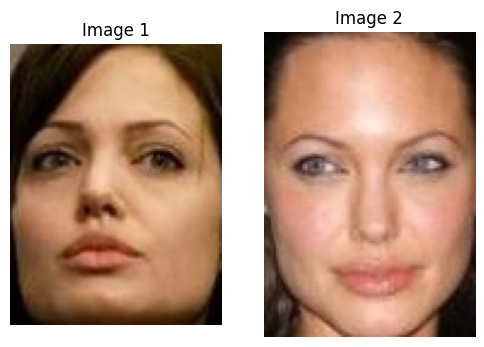

In [51]:
# Example on same person images from LFW dataset
image1_path = '/kaggle/input/lfw-deepfunneled-cropped/Angelina_Jolie/Angelina_Jolie_0007.jpg'
image2_path = '/kaggle/input/lfw-deepfunneled-cropped/Angelina_Jolie/Angelina_Jolie_0006.jpg'
plot_images(image1_path, image2_path)
distance = compute_distance(image1_path, image2_path, model, distance_metric='euclidean')
print(f"Euclidian distance between images: {distance}")

distance = compute_distance(image1_path, image2_path, model, distance_metric='cosine')
print(f"Cosine distance between images: {distance}")

Euclidian distance between images: 1.5718028545379639
Cosine distance between images: 0.9942759275436401


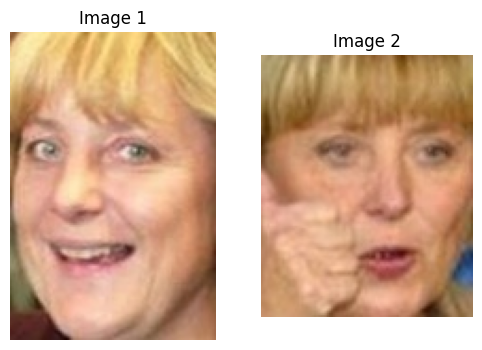

In [29]:
# Example on same person images from LFW dataset
image1_path = '/kaggle/input/lfw-deepfunneled-cropped/Angela_Merkel/Angela_Merkel_0001.jpg'
image2_path = '/kaggle/input/lfw-deepfunneled-cropped/Angela_Merkel/Angela_Merkel_0003.jpg'
plot_images(image1_path, image2_path)
distance = compute_distance(image1_path, image2_path, model, distance_metric='euclidean')
print(f"Euclidian distance between images: {distance}")

distance = compute_distance(image1_path, image2_path, model, distance_metric='cosine')
print(f"Cosine distance between images: {distance}")

Euclidian distance between images: 1.7488592863082886
Cosine distance between images: 0.9926076531410217


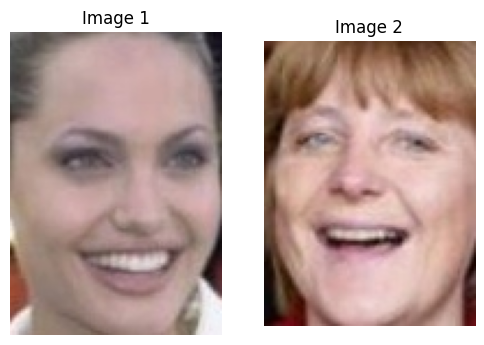

In [52]:
# Example on different person images from LFW dataset
image1_path = '/kaggle/input/lfw-deepfunneled-cropped/Angelina_Jolie/Angelina_Jolie_0001.jpg'
image2_path = '/kaggle/input/lfw-deepfunneled-cropped/Angela_Merkel/Angela_Merkel_0005.jpg'
plot_images(image1_path, image2_path)
distance = compute_distance(image1_path, image2_path, model, distance_metric='euclidean')
print(f"Euclidian distance between images: {distance}")

distance = compute_distance(image1_path, image2_path, model, distance_metric='cosine')
print(f"Cosine distance between images: {distance}")

In [39]:
def load_and_preprocess_image(image_path):
    # Loading images and transforming
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image.unsqueeze(0)

def extract_faces_and_compute_distance(model, image_path1, image_path2, distance_metric='euclidean'):
    # Extracting faces
    face_image1 = DeepFace.extract_faces(image_path1,
                                         #target_size=(224, 224),
                                         detector_backend='yolov8')
    face_image2 = DeepFace.extract_faces(image_path2,
                                         #target_size=(224, 224),
                                         detector_backend='yolov8')

    # Convert images to PIL Image format and reshape to (224, 224)
    face_pil_image1 = Image.fromarray((face_image1[0]['face'] * 255).astype(np.uint8))
    face_pil_image2 = Image.fromarray((face_image2[0]['face'] * 255).astype(np.uint8))

    # Converting to tensors
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    face_tensor1 = preprocess(face_pil_image1).unsqueeze(0)
    face_tensor2 = preprocess(face_pil_image2).unsqueeze(0)

    # Converting to CUDA
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    face_tensor1 = face_tensor1.to(device)
    face_tensor2 = face_tensor2.to(device)

    # Inference
    with torch.no_grad():
        output1 = model(face_tensor1)
        output2 = model(face_tensor2)

    # Computing distance metrics
    if distance_metric == 'euclidean':
        distance = torch.norm(output1 - output2)
    elif distance_metric == 'cosine':
        distance = torch.nn.functional.cosine_similarity(output1, output2)
    else:
        raise ValueError("False distance metrics. Available metrics are: 'euclidean' or 'cosine'.")

    return distance.item()  # Getting distance measure as a number


## Testing on my and my friends' images

In [59]:
!git clone https://github.com/Memirlan/Metric-Learning-for-FaceID.git

Cloning into 'Metric-Learning-for-FaceID'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 45 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 13.69 MiB | 19.18 MiB/s, done.
Resolving deltas: 100% (7/7), done.


Euclidian distance between images: 2.0782687664031982
Cosine distance between images: 0.9973759651184082


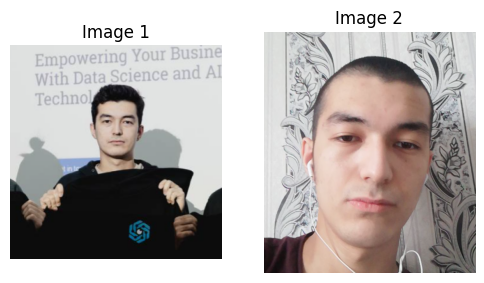

In [68]:
# Example on same people images from our group
image1_path = '/kaggle/working/Metric-Learning-for-FaceID/test_faces/Temirlan/Tema1.png'
image2_path = '/kaggle/working/Metric-Learning-for-FaceID/test_faces/Temirlan/Tema3.png'
plot_images(image1_path, image2_path)
distance = extract_faces_and_compute_distance(model, image1_path, image2_path, distance_metric='euclidean')
print(f"Euclidian distance between images: {distance}")
distance = compute_distance(image1_path, image2_path, model, distance_metric='cosine')
print(f"Cosine distance between images: {distance}")

Euclidian distance between images: 0.8999764323234558
Cosine distance between images: 0.9976140260696411


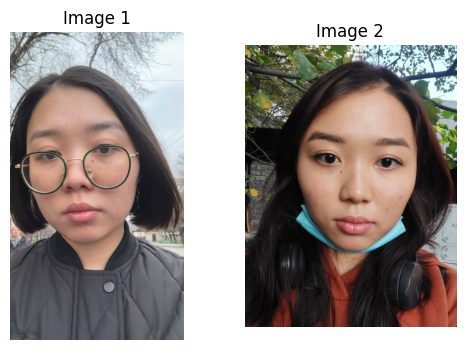

In [77]:
# Example on same people images from our group
image1_path = '/kaggle/working/Metric-Learning-for-FaceID/test_faces/Ayazhan/Ayazhan2.png'
image2_path = '/kaggle/working/Metric-Learning-for-FaceID/test_faces/Ayazhan/Ayazhan3.png'
plot_images(image1_path, image2_path)
distance = extract_faces_and_compute_distance(model, image1_path, image2_path, distance_metric='euclidean')
print(f"Euclidian distance between images: {distance}")
distance = compute_distance(image1_path, image2_path, model, distance_metric='cosine')
print(f"Cosine distance between images: {distance}")

Euclidian distance between images: 2.5995447635650635
Cosine distance between images: 0.9976882934570312


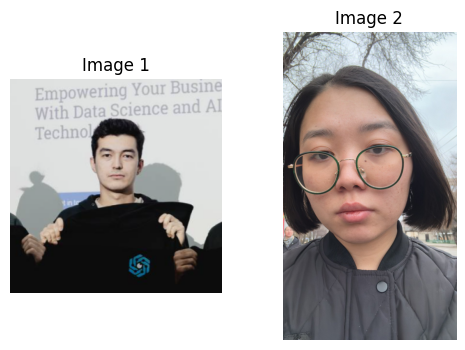

In [81]:
# Example on different people from our group
image1_path = '/kaggle/working/Metric-Learning-for-FaceID/test_faces/Temirlan/Tema1.png'
image2_path = '/kaggle/working/Metric-Learning-for-FaceID/test_faces/Ayazhan/Ayazhan2.png'
plot_images(image1_path, image2_path)
distance = extract_faces_and_compute_distance(model, image1_path, image2_path, distance_metric='euclidean')
print(f"Euclidian distance between images: {distance}")
distance = compute_distance(image1_path, image2_path, model, distance_metric='cosine')
print(f"Cosine distance between images: {distance}")

Euclidian distance between images: 0.9593821167945862
Cosine distance between images: 0.993533194065094


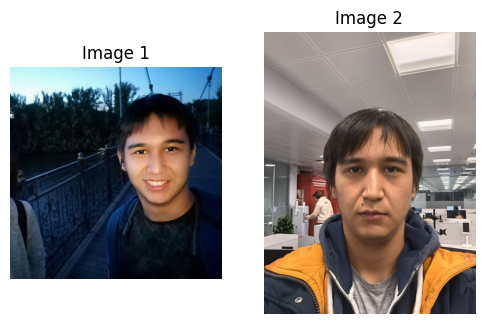

In [94]:
# Example on same people images from our group
image1_path = '/kaggle/working/Metric-Learning-for-FaceID/test_faces/Alikhan/Alikhan1.png'
image2_path = '/kaggle/working/Metric-Learning-for-FaceID/test_faces/Alikhan/Alikhan4.png'
plot_images(image1_path, image2_path)
distance = extract_faces_and_compute_distance(model, image1_path, image2_path, distance_metric='euclidean')
print(f"Euclidian distance between images: {distance}")
distance = compute_distance(image1_path, image2_path, model, distance_metric='cosine')
print(f"Cosine distance between images: {distance}")

Euclidian distance between images: 1.3783535957336426
Cosine distance between images: 0.9917553663253784


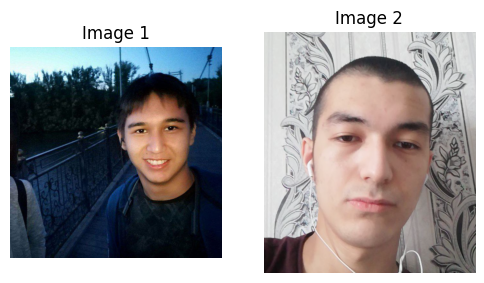

In [95]:
# Example on different people from our group
image1_path = '/kaggle/working/Metric-Learning-for-FaceID/test_faces/Alikhan/Alikhan1.png'
image2_path = '/kaggle/working/Metric-Learning-for-FaceID/test_faces/Temirlan/Tema3.png'
plot_images(image1_path, image2_path)
distance = extract_faces_and_compute_distance(model, image1_path, image2_path, distance_metric='euclidean')
print(f"Euclidian distance between images: {distance}")
distance = compute_distance(image1_path, image2_path, model, distance_metric='cosine')
print(f"Cosine distance between images: {distance}")